# <font color='blue'>Barnes, R. "Gene"</font> - <font color='purple'><u>MIS670 Capstone Project</u></font> - 5/7/2018

## <font color='purple'>K-State Honor Code:</font> "On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

In [1]:
# ++++++++++++++++++Popular Packages Section+++++++++++++++++++++++++++++++++++++++++++++
import io
import json
import requests
import urllib2
import datetime
import csv
import time
import nltk
import re
import sklearn
import logging
import seaborn as sns
import numpy as np
import pandas as pd

#++++++++++++++++++++Web Scraping++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from lxml import html
import urllib2
from bs4 import BeautifulSoup as bsoup
from urllib2 import urlopen
from time import sleep
from selenium import webdriver

#++++++++++++++++++++Word Preparation/Processing Section+++++++++++++++++++++++++++++++++++
# Word Analysis with NLTK; stopwords, FreqDist, word_tokenize
from nltk import tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pattern.en import sentiment
from collections import Counter

# To ignore all warnings that arise here to enhance clarity
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim') 

#++++++++++++++++++++Data Visualization Section+++++++++++++++++++++++++++++++++++++++++++
# Gensim packages
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

# Other Gensim and Sklearn packages for NFM, LSI, and LDA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile

# Network Analytics (clustering)
#to measure distance or similarity between documents or texts
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

#clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

# WordCloud, MatPlot & other visualization packages
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
% matplotlib inline
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# 1. Data identification and collection (e.g., source of the dataset, method of data collection). 

## The tasks at hand here are to obtain the following data:
1. Find reviews of the best KS College Dorm according to Niche.
2. Find reviews of the worst KS College Dorm according to Niche.
3. Run analysis to compare the data/statistics for each.
4. If possible, use analysis methods that were not learned in class.


## For the method of data collection, let's use the Python package Selenium (not learned in class) to "scrape" the data from Niche's website. This also automates the selection of the "Next" button to help advance to the next page of reviews until all reviews are scraped.

In [2]:
# Selenium setup, using Chrome browser
driver = webdriver.Chrome()

# Chrome opens URL given for K-State Reviews (KSU happens to be the best KS College dorm ranking)
driver.get("https://www.niche.com/colleges/kansas-state-university/reviews/")

# Create array (dict) for reviews
ksu_reviews=[]

# Count the number of reviews for K-State
ksu_count = 0

# Loop to find review text on page and append it to array
while True:
    for review in driver.find_elements_by_xpath("//div[@itemprop='reviewBody']"): 
        ksu_reviews.append(review.text)
        ksu_count = ksu_count + 1

    try: # Selenium looks for "Next" button for pagination; this is what helps to scrape each page until it runs out of pages    
        next_link = driver.find_element_by_xpath("//span[@class='icon-arrowright-thin--pagination']")
        next_link.click()
        time.sleep(3)
    except:
        break

In [3]:
# Display total number of reviews
print "There are", ksu_count, "reviews for K-State in this dataset."

There are 1740 reviews for K-State in this dataset.


In [4]:
# save file to txt for use later
with open("data/ksu-reviews.txt", "w") as output:
    output.write(str(ksu_reviews))

In [5]:
# You can create a csv file for further analysis using Tabular, Excel, etc.
ksudf = pd.DataFrame(ksu_reviews)

ksudf.to_csv('data/ksu_reviews.csv', encoding='utf-8', header=False, index=False)
# Now we can run analysis on the data.

In [6]:
# checking to see if data is in array
ksudf.head()

0
0  Kansas State was my first choice in schools to...
1  Amazing! I enjoyed every little thing about it...
2  Kansas State is such an amazing college. Every...
3  Kansas State University provides a very family...
4  I love how the campus really tries their best ...

In [7]:
# Selenium setup, using Chrome browser
driver = webdriver.Chrome()

# Chrome opens URL given for University of KS, which happens to be the worst KS College dorms rated
driver.get("https://www.niche.com/colleges/university-of-kansas/reviews/")

# Create array (dict) for reviews
ku_reviews=[]

# Count the number of reviews for University of KS
ku_count = 0

# Loop to find review text on page and append it to array
while True:
    for review in driver.find_elements_by_xpath("//div[@itemprop='reviewBody']"): 
        ku_reviews.append(review.text)
        ku_count = ku_count + 1

    try: # Selenium looks for "Next" button for pagination; this is what helps to scrape each page until it runs out of pages    
        next_link = driver.find_element_by_xpath("//span[@class='icon-arrowright-thin--pagination']")
        next_link.click()
        time.sleep(3)
    except:
        break

In [8]:
# Display total number of reviews
print "There are", ku_count, "reviews for Univ. of Kansas in this dataset."

There are 780 reviews for Univ. of Kansas in this dataset.


In [9]:
# save file to txt for use later
with open("data/ku-reviews.txt", "w") as output:
    output.write(str(ku_reviews))

In [10]:
# You can create a csv file for further analysis using Tabular, Excel, etc.
kudf = pd.DataFrame(ku_reviews)
kudf.to_csv('data/ku_reviews.csv', encoding='utf-8', header=False, index=False)
# Now we can run analysis on the data.

In [11]:
# checking to see if data is in array
kudf.head()

0
0  University of Kansas is a very nice university...
1  Academics are great! Great professors! The cam...
2  As both of my parents went there and I live in...
3  Overall, the University of Kansas is a great p...
4  KU really wasn't all that I was expecting. Som...

In [12]:
#specify the url
niche = "https://www.niche.com/colleges/search/best-college-dorms/s/kansas/?type=public"

#Query the website and return the html to the variable 'page'
page = urllib2.urlopen(niche)

#Parse the html in the 'page' variable, and store it in Beautiful Soup format
soup = bsoup(page, "lxml")

n_pretty=soup.prettify()

In [13]:
# scrape URL for all KS colleges listed
schools=[]
all_links = soup.find_all("a")
for link in all_links:
    schools.append(link.get("href"))

In [14]:
# get school name
u_title=soup.find_all('h2', class_='search-result__title')

# get school's Niche ranking
u_score=soup.find_all('span', class_='search-result-badge-ordinal')

In [15]:
# combine results to one array for saving
final_score = zip(u_title,u_score)
# changing the data more like Excel format
fsdf = pd.DataFrame(final_score)
# then save
fsdf.to_csv("data/fsdf.csv", encoding='utf-8', header=False, index=False)

In [16]:
# ensure we have the data
fsdf

0  \
0  <h2 class="search-result__title">Kansas State ...   
1  <h2 class="search-result__title">Emporia State...   
2  <h2 class="search-result__title">Pittsburg Sta...   
3  <h2 class="search-result__title">Washburn Univ...   
4  <h2 class="search-result__title">Haskell India...   

                                                   1  
0  <span class="search-result-badge-ordinal">200<...  
1  <span class="search-result-badge-ordinal">227<...  
2  <span class="search-result-badge-ordinal">249<...  
3  <span class="search-result-badge-ordinal">452<...  
4  <span class="search-result-badge-ordinal">494<...

# 2. Business and data understanding

### Problem Statement:
K-State Housing and Dining Services is always looking to improve the on-campus living areas (residential halls, apartments) by looking at several types of data, including social media. In this instance, we will use Niche to compare KSU to KU by ranking.

### Business Contexts:
Knowing how our current and future residential students actually feel is good or bad about our residential areas on campus can help our department determine when and where to apply updates to facilities. 

### The Significance of the Problem:
A potential student for any Kansas college may be determined by the on-campus living areas of the college. We have found that on-campus living does increase total enrollment of the college, success of the student to continue to the next classification, and improve the overall GPA and graduation rates.

### The Business Value of the Solution:
Increased enrollment means increased revenue from monies spent for housing, dining, student organizations, books, clothes, etc. for the student during their academic pursuit. 

# 3. Data cleaning & text preprocessing processing (e.g., tokenization, stopword)

In [17]:
# Word cleaning and processing
# currently the data are in list ... convert to string
tokens = str(ksu_reviews)
tokens2 = str(ku_reviews)

# lowecases
tokens = tokens.lower()
tokens2 = tokens2.lower()

# Remove useless numbers and alphanumerical words
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)
tokens2 = re.sub("[^a-zA-Z0-9]", " ", tokens2)

# tokenization or word split
tokens = word_tokenize(tokens)
tokens2 = word_tokenize(tokens2)

# get stemming words or lemmas
wordnet_lemmatizer = WordNetLemmatizer()
tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)
tokens2 = (wordnet_lemmatizer.lemmatize(word) for word in tokens2)

# Remove stopwords
more_stopwords = set(('span', 'http', 'com', 'edu', 'year', 'abuse', 'campus', 'university', 'school'))
extra_stoplist = set(stopwords.words('english')) | more_stopwords
tokens = (word for word in tokens if word not in extra_stoplist)
tokens2 = (word for word in tokens2 if word not in extra_stoplist)

# Filter non-alphanumeric characters from tokens
tokens = (word for word in tokens if word.isalpha())
tokens2 = (word for word in tokens2 if word.isalpha())

#remove short words
tokens = (word for word in tokens if len(word) >= 3)
tokens2 = (word for word in tokens2 if len(word) >= 3)

# compute frequency distribution for all the bigrams in the text
fdist_ksu = nltk.FreqDist(tokens)
fdist_ku = nltk.FreqDist(tokens2)

In [18]:
# We can convert array to dataframe
ksu_df = pd.DataFrame(tokens)
ku_df = pd.DataFrame(tokens2)

In [19]:
# You can create a csv file for further analysis using Tabular, Excel, etc.
ksu_df.to_csv('data/ksu_df.csv', encoding='utf-8', header=False, index=False)
ku_df.to_csv('data/ku_df.csv', encoding='utf-8', header=False, index=False)
# Now we can run analysis on the data.

# 4. Descriptive Analytics: We will use word frequency, simple line plots, word cloud, pivot tables (e.g., groupby), descriptive statistics, to analyze the words within the college reviews.

## Results for KSU

In [20]:
# show the 20 most common words
fdist_ksu.most_common(20)

[('state', 421),
 (u'student', 412),
 ('great', 345),
 ('people', 253),
 ('get', 245),
 ('like', 215),
 ('lot', 211),
 ('really', 201),
 ('many', 197),
 (u'kansa', 196),
 ('love', 185),
 ('one', 172),
 ('class', 172),
 ('greek', 168),
 ('everyone', 162),
 ('feel', 161),
 ('always', 151),
 ('family', 147),
 ('good', 136),
 ('life', 135)]

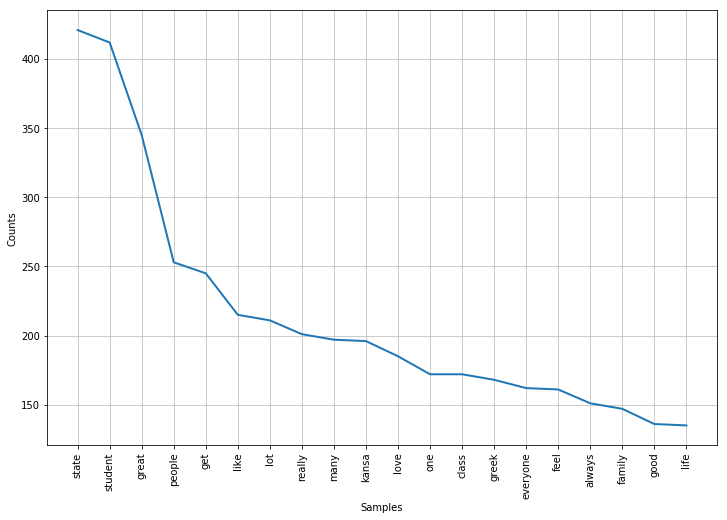

In [21]:
# create plot of word frequency
plt.figure(figsize=(12,8))
fdist_ksu.plot(20)

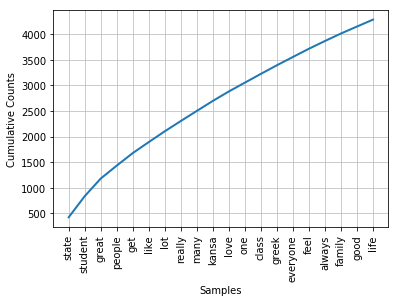

In [22]:
# Cumulative counts plot of word frequency
fdist_ksu.plot(20,cumulative=True)

In [23]:
# What word in word frequency has the highest count?
print "The word with the greatest number of usage is:", fdist_ksu.max()

The word with the greatest number of usage is: state


In [24]:
# prepare the results of word frequency on review data as a list
freq_word_ksu = []

# two values or columns in fdist_a
for k,v in fdist_ksu.items():
    freq_word_ksu.append([k,v])

#make it like an Excel worksheet
wl_ksu = pd.DataFrame(freq_word_ksu)

In [25]:
# View the data of words and their frequencies, first 10 of list
wl_ksu.head(10)

0  1
0       limited  3
1  philantrophy  1
2         child  3
3     desirable  1
4          four  8
5           nwe  1
6       protest  1
7         asian  6
8       hanging  3
9   grandparent  1

In [26]:
# top five words
wl_sort_ksu = wl_ksu.sort_values(1, ascending=False).head(5)
wl_sort_ksu

0    1
2797    state  421
2898  student  412
2449    great  345
647    people  253
1244      get  245

In [27]:
# rename column names
wl_ksu = wl_ksu.rename(columns={0: 'word', 1: 'freq'})
wl_ksu.tail(10)

word  freq
3109       kinda     1
3110      priced     3
3111   prevalent     4
3112  persistent     1
3113        rule    15
3114     portion     2
3115        lift     1
3116      status     1
3117       rural     4
3118       baked     1

In [28]:
# You can create a csv file for further analysis using Tabular, Excel, etc.
wl_ksu.to_csv('data/wl_ksu.csv', encoding='utf-8', header=False, index=False)

In [29]:
# describe analysis of data
wl_ksu['word'].describe()

count     3119
unique    3119
top       ruin
freq         1
Name: word, dtype: object

Here's what people are saying about KSU!


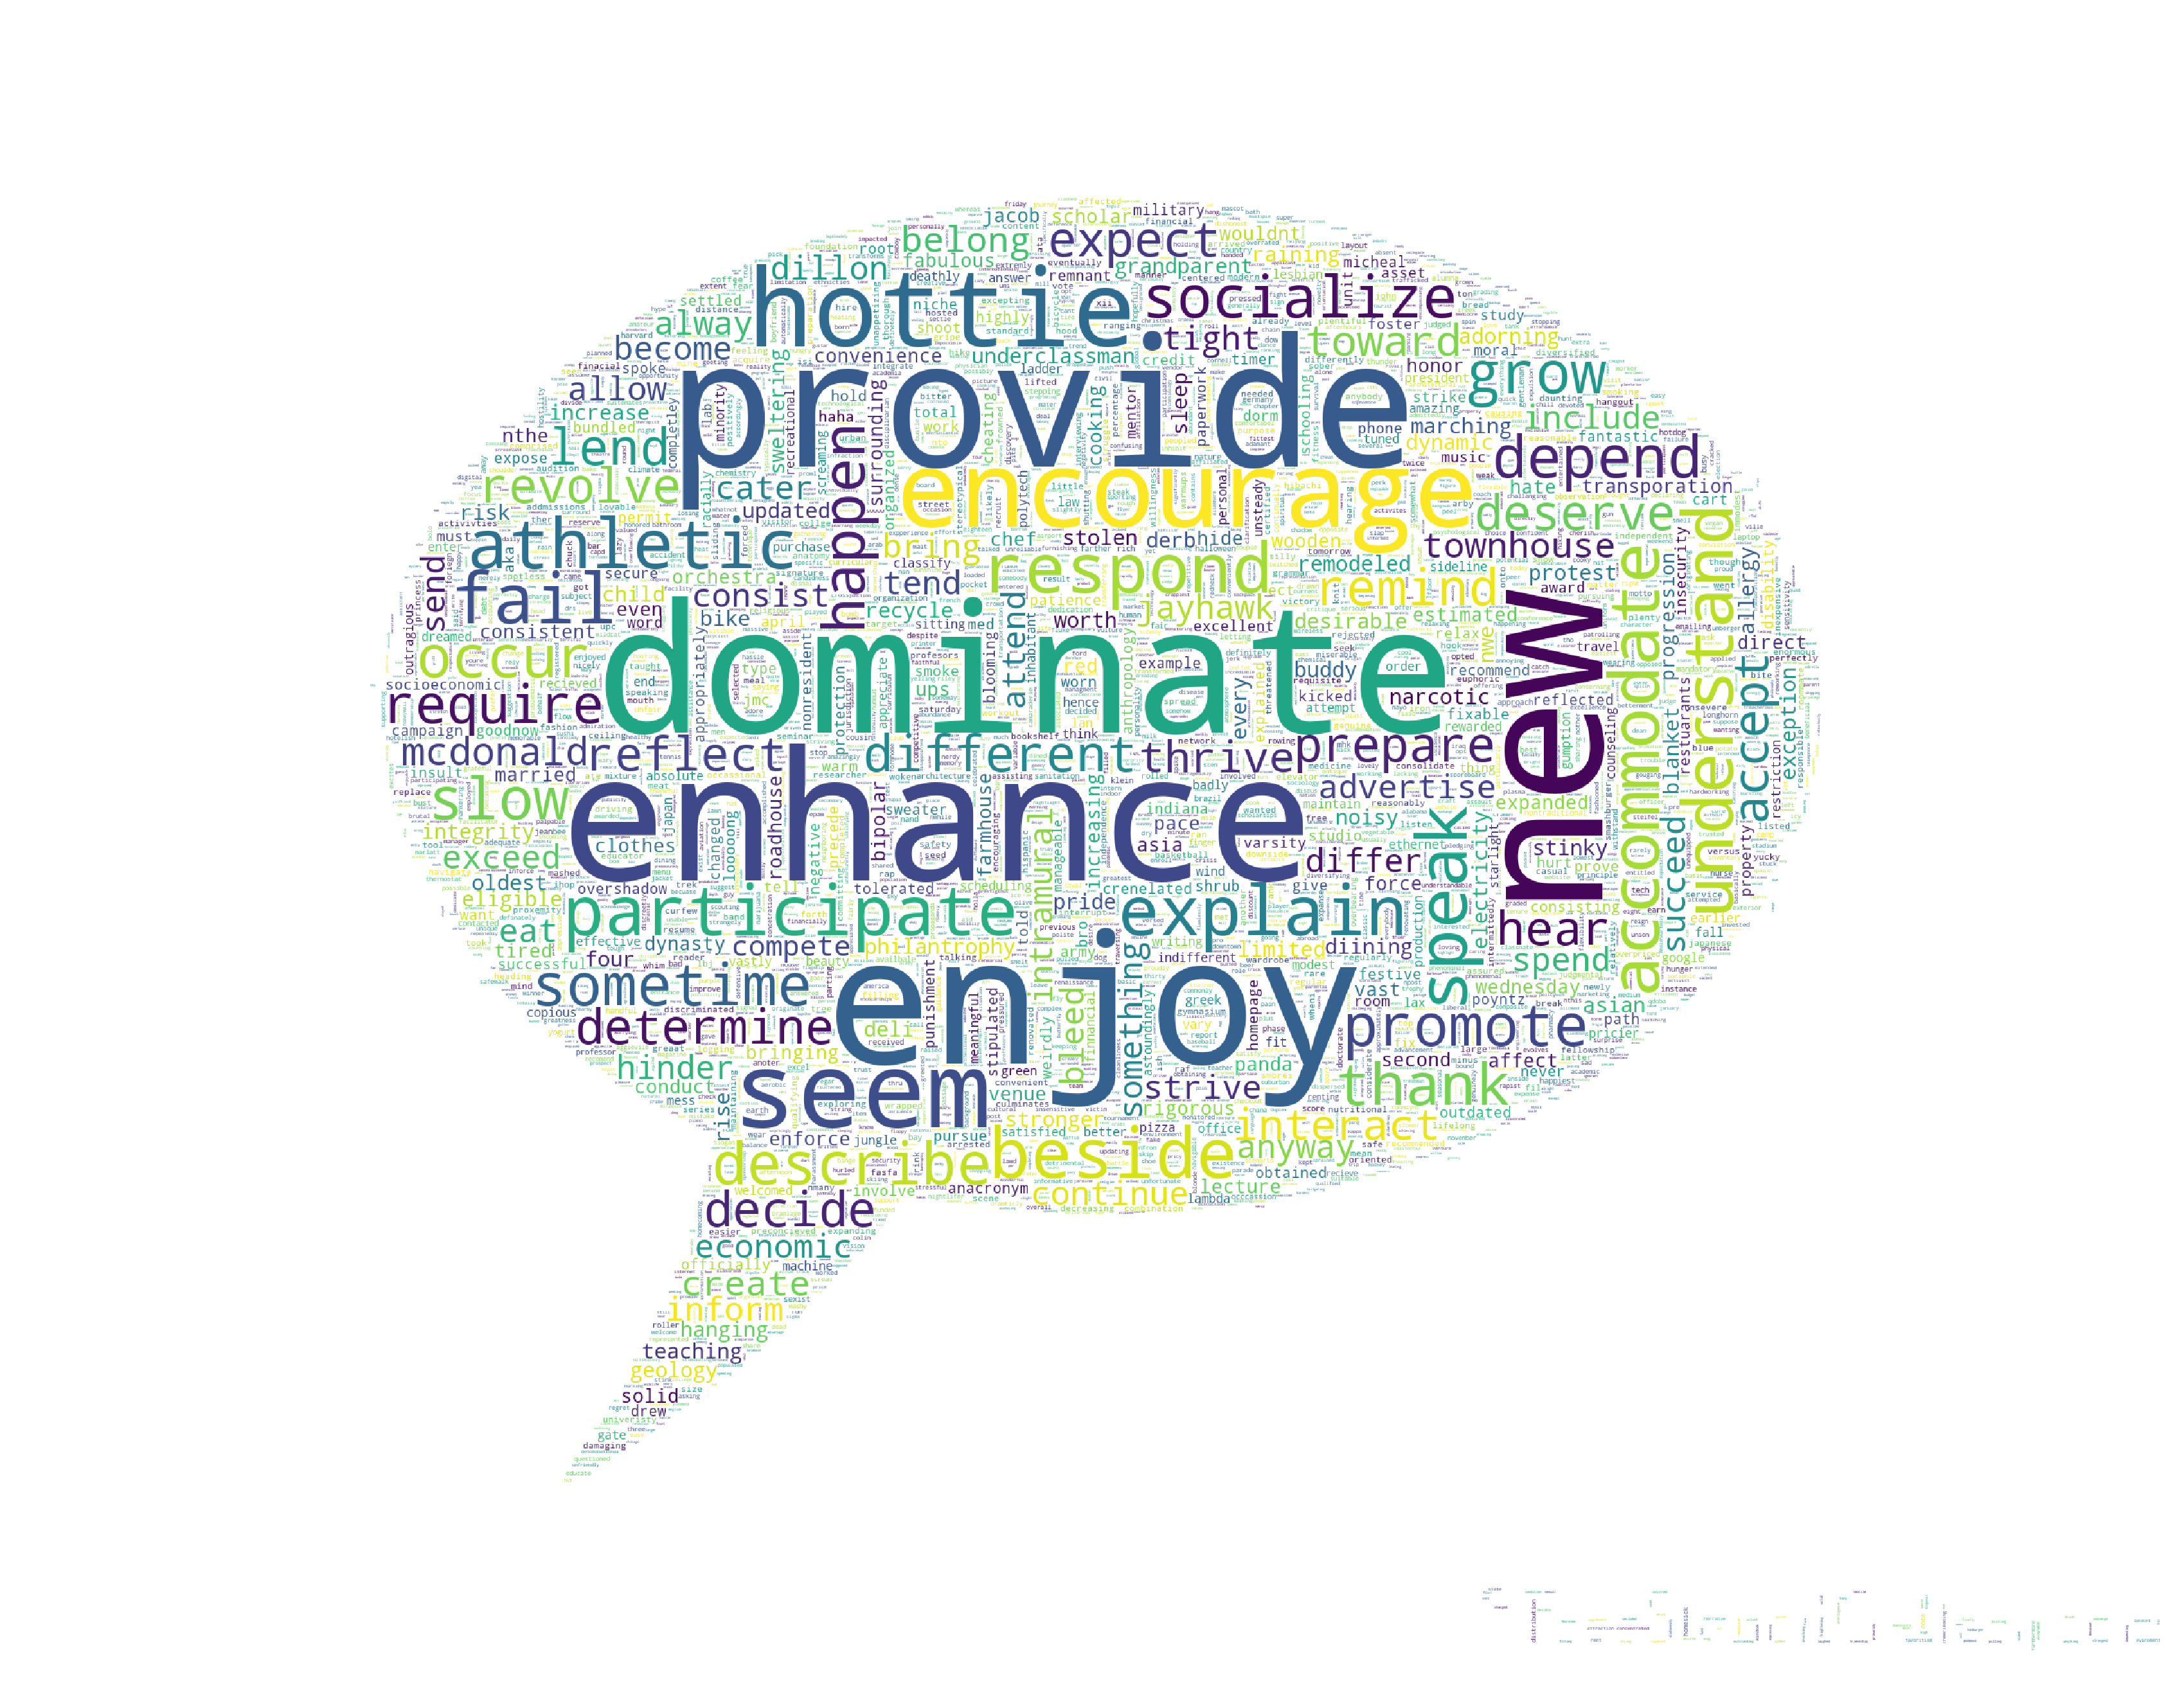

In [30]:
# Positive Review word cloud
d = path.dirname("data/")

# Read the whole text.
text = open(path.join(d, 'wl_ksu.txt')).read()

# read the mask image
# taken from http://www.freestencilgallery.com/?s=auto
mask = np.array(Image.open(path.join(d, "speech-bubble-stencil.png")))


# set up stopwords to remove from text
more = set(('span', 'http', 'com', 'edu', 'year', 'abuse', 'campus', 'university', 'school'))
stopwords = set(STOPWORDS) | more

# create wordcloud using png file as background shape
wc = WordCloud(background_color="white", max_words=5000, mask=mask,
               stopwords=stopwords)

# generate wordcloud
wc.generate(text)

# show word cloud
plt.figure(figsize=(60,60))
plt.imshow(wc)
plt.axis("off")
print "Here's what people are saying about KSU!"

# save images for later use
plt.savefig("data/ksu_niche_review.png")
plt.savefig("data/ksu_niche_review.pdf")

## Results for KU

In [31]:
# show the 20 most common words
fdist_ku.most_common(20)

[(u'student', 183),
 ('great', 173),
 ('get', 124),
 (u'class', 120),
 ('like', 112),
 (u'professor', 107),
 ('people', 107),
 ('lot', 104),
 ('really', 99),
 ('good', 98),
 (u'dorm', 97),
 ('life', 97),
 (u'kansa', 96),
 ('experience', 94),
 ('best', 87),
 ('love', 87),
 ('one', 83),
 ('college', 83),
 ('greek', 81),
 ('always', 81)]

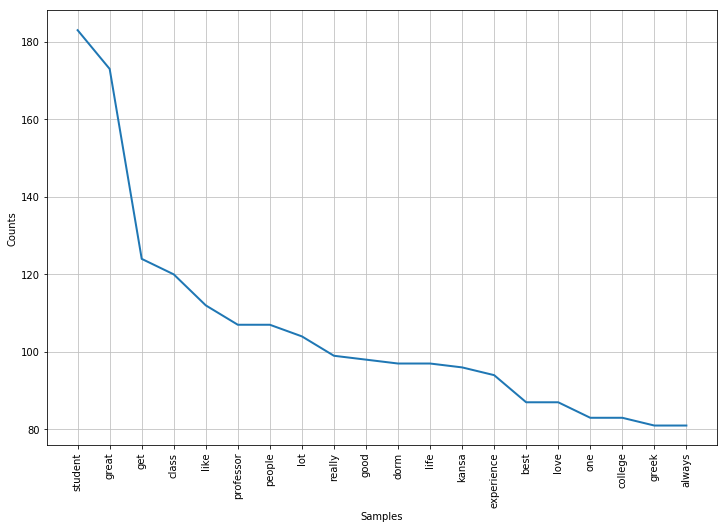

In [32]:
# create plot of word frequency
plt.figure(figsize=(12,8))
fdist_ku.plot(20)

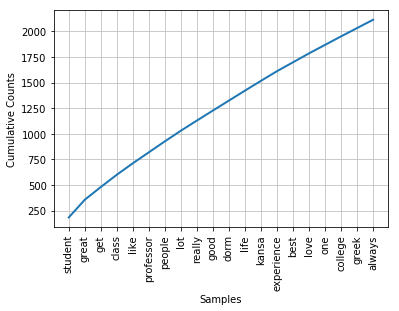

In [33]:
# Cumulative counts plot of word frequency
fdist_ku.plot(20,cumulative=True)

In [34]:
# What word in word frequency has the highest count?
print "The word with the greatest number of usage is:", fdist_ku.max()

The word with the greatest number of usage is: student


In [35]:
# prepare the results of word frequency on review data as a list
freq_word_ku = []

# two values or columns in fdist_a
for k,v in fdist_ku.items():
    freq_word_ku.append([k,v])

#make it like an Excel worksheet
wl_ku = pd.DataFrame(freq_word_ku)

In [36]:
# View data to see the words and their frequency
wl_ku.head(10)

0   1
0          limited   4
1            retch   1
2  extracurricular   1
3             felt  14
4             four   2
5          protest   1
6            sleep   2
7            asian   2
8          hanging   1
9          captain   1

In [37]:
# top five words
wl_sort_ksu = wl_ku.sort_values(1, ascending=False).head(5)
wl_sort_ksu

0    1
2038  student  183
1712    great  173
838       get  124
1892    class  120
2073     like  112

In [38]:
# rename column names
wl_ku = wl_ku.rename(columns={0: 'word', 1: 'freq'})
wl_ku.tail(10)

word  freq
2163     knowlegde     1
2164          stay     3
2165        chance     8
2166  additionally     1
2167      tailgate     1
2168           gap     1
2169         using     1
2170         jewel     1
2171          rule     7
2172     diagnosis     1

In [39]:
# You can create a csv file for further analysis using Tabular, Excel, etc.
wl_ku.to_csv('data/wl_ku.csv', encoding='utf-8', header=False, index=False)

In [40]:
# describe analysis of data
wl_ku['word'].describe()

count     2173
unique    2173
top       ruin
freq         1
Name: word, dtype: object

Here's what people are saying about KU!


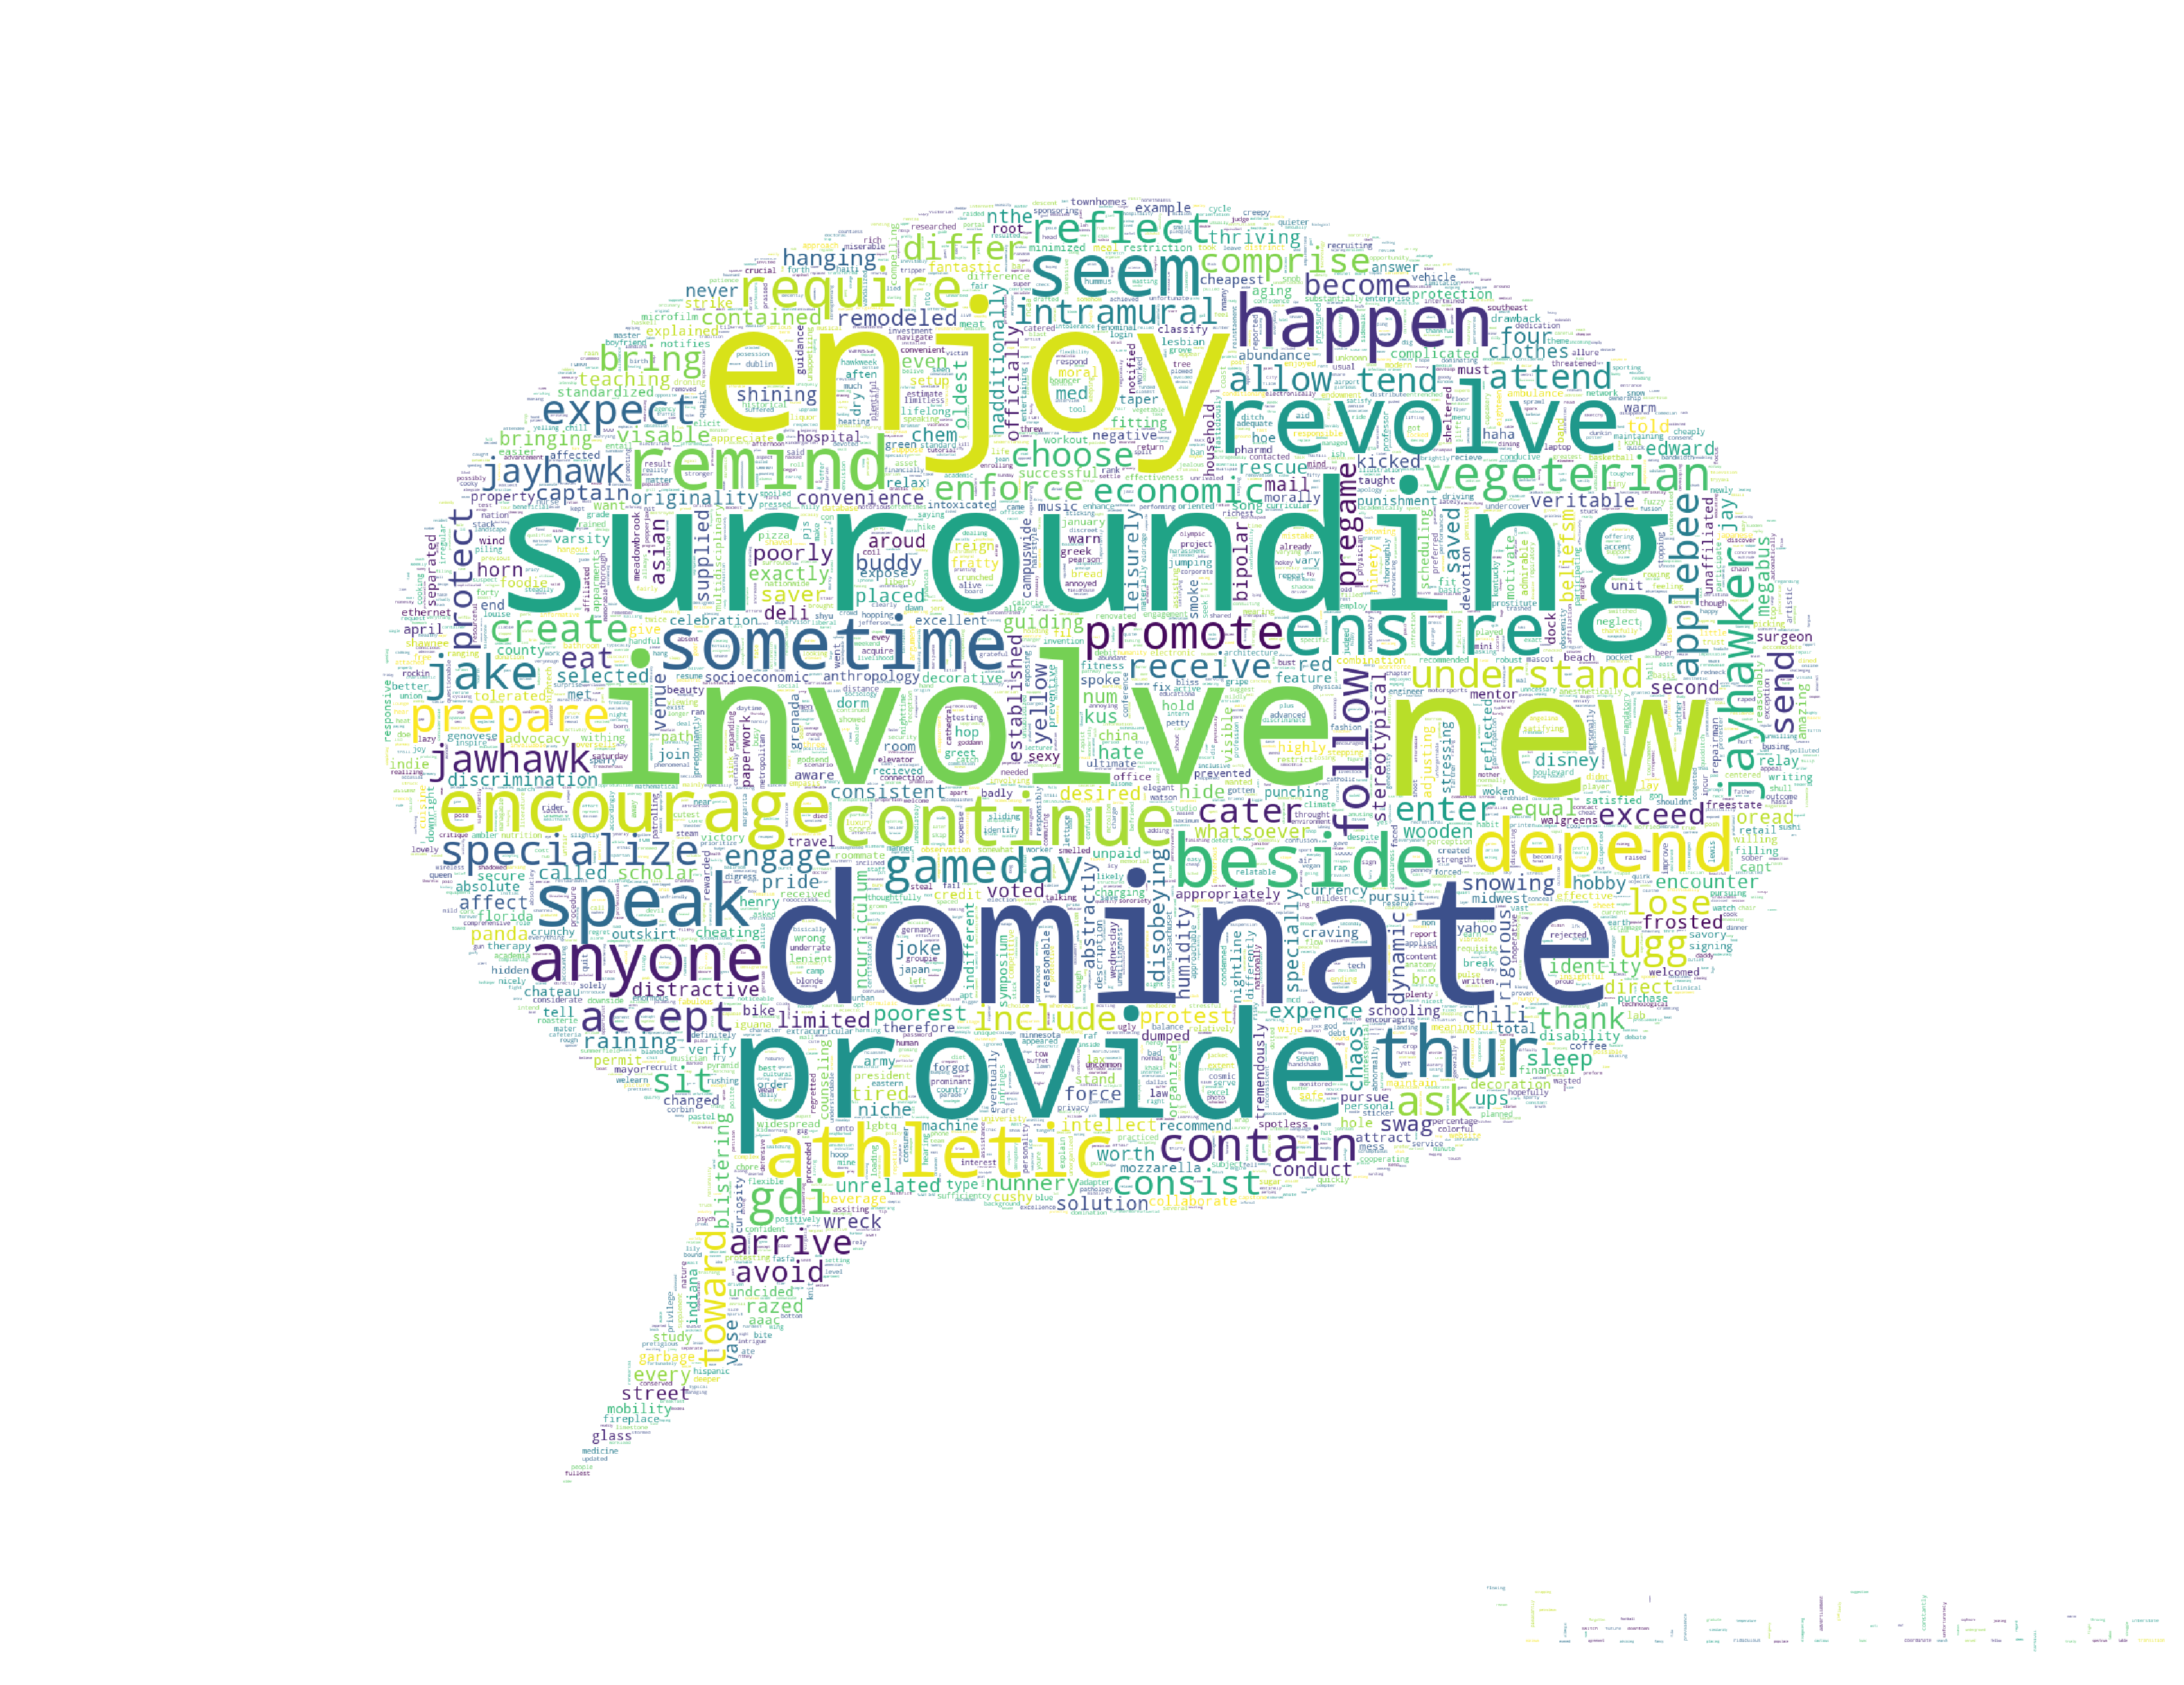

In [41]:
# Positive Review word cloud
d = path.dirname("data/")

# Read the whole text.
text = open(path.join(d, 'wl_ku.txt')).read()

# read the mask image
# taken from http://www.freestencilgallery.com/?s=auto
mask = np.array(Image.open(path.join(d, "speech-bubble-stencil.png")))
#mask = np.array(Image.open(path.join(d, "jayhawk_head.png")))

# set up stopwords to remove from text
more = set(('span', 'http', 'com', 'edu', 'year', 'abuse', 'kansa', 'campu', 'university', 'school'))
stopwords = set(STOPWORDS) | more

# create wordcloud using png file as background shape
wc = WordCloud(background_color="white", max_words=5000, mask=mask,
               stopwords=stopwords)

# generate wordcloud
wc.generate(text)

# show word cloud
plt.figure(figsize=(60,60))
plt.imshow(wc)
plt.axis("off")
print "Here's what people are saying about KU!"

# save images for later use
plt.savefig("data/ku_niche_review.png")
plt.savefig("data/ku_niche_review.pdf")

## What are the findings from descriptive analytics?

# 5. Content analytics: We will use sentiment analysis (positive, negative or neutral) of the college reviews.

## Sentiment Analysys: KSU

In [42]:
# read data file for analysis
openfile = io.open("data/ksu_reviews.csv", "rb")
r = csv.reader(openfile)
ksu2_reviews = [] 
for i in r:
    ksu2_reviews.append(i)
openfile.close()

In [43]:
# break out rows and save file
ksuscore=[]
for row in ksu2_reviews:
    ksuscore.append(sentiment(row[0]))

output=zip(ksuscore)
writer = csv.writer(io.open('data/ksu_sentiment_score.csv', 'wb'))
writer.writerows(output)

C:\Users\Gene\Anaconda2\lib\site-packages\pattern\text\__init__.py:1943: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if w in imap(lambda e: e.lower(), e):
C:\Users\Gene\Anaconda2\lib\site-packages\pattern\text\__init__.py:979: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  and tokens[j] in ("'", "\"", u"”", u"’", "...", ".", "!", "?", ")", EOS):


In [44]:
# Sentiment analysis using Pattern
# setup empty lists for reviews
positive_review = []
negative_review = []
neutral_review = []

# test reviews for sentiment score and separate by result, positive, negative, or neutral
for row in ksu2_reviews:
    ksureviews = row[0]
    PTscore = sentiment(ksureviews)
    if PTscore[0] > 0:
        positive_review.append(ksureviews)
    elif PTscore[0] == 0:
        neutral_review.append(ksureviews)
    else:
        negative_review.append(ksureviews) 

In [45]:
# Display results of sentiment anaylysis using Pattern
print "From the dataset, there are", len(positive_review), "positive reviews using Pattern sentiment analysis."
print "From the dataset, there are", len(negative_review), "negative reviews using Pattern sentiment analysis."
print "From the dataset, there are", len(neutral_review), "neutral reviews using Pattern sentiment analysis."

From the dataset, there are 1376 positive reviews using Pattern sentiment analysis.
From the dataset, there are 193 negative reviews using Pattern sentiment analysis.
From the dataset, there are 171 neutral reviews using Pattern sentiment analysis.


## Sentiment Analysys: KU

In [46]:
# read data file for analysis
openfile = open("data/ku_reviews.csv", "rb")
r = csv.reader(openfile)
ku2_reviews = [] 
for i in r:
    ku2_reviews.append(i)
openfile.close()

In [47]:
# break out rows and save file
kuscore=[]
for row in ku2_reviews:
    kuscore.append(sentiment(row[0]))

output=zip(kuscore)
writer = csv.writer(io.open('data/ks_sentiment_score.csv', 'wb'))
writer.writerows(output)

In [48]:
# Sentiment analysis using Pattern
# setup empty lists for reviews
positive_review2 = []
negative_review2 = []
neutral_review2 = []

# test reviews for sentiment score and separate by result, positive, negative, or neutral
for row in ku2_reviews:
    kureviews = row[0]
    PTscore = sentiment(kureviews)
    if PTscore[0] > 0:
        positive_review2.append(kureviews)
    elif PTscore[0] == 0:
        neutral_review2.append(kureviews)
    else:
        negative_review2.append(kureviews) 

In [49]:
# Display results of sentiment anaylysis using Pattern
print "From the dataset, there are", len(positive_review2), "positive reviews using Pattern sentiment analysis."
print "From the dataset, there are", len(negative_review2), "negative reviews using Pattern sentiment analysis."
print "From the dataset, there are", len(neutral_review2), "neutral reviews using Pattern sentiment analysis."

From the dataset, there are 624 positive reviews using Pattern sentiment analysis.
From the dataset, there are 76 negative reviews using Pattern sentiment analysis.
From the dataset, there are 80 neutral reviews using Pattern sentiment analysis.


# 6. Network analytics: Clustering groups (using k-value method).

## Results for KSU.

In [50]:
# open spreadsheet to obtain data for analysis
openfile = open("data/ksu_reviews.csv", "rb")
r = csv.reader(openfile)
ksu_content = [] 
for i in r:
    ksu_content.append(i)
openfile.close()    

In [51]:
# display number of documents with content (aka reviews)
len(ksu_content)

1740

In [52]:
# converting csv list to dataframe
ksucon = pd.DataFrame(ksu_content)
ksucon.head()

0
0  Kansas State was my first choice in schools to...
1  Amazing! I enjoyed every little thing about it...
2  Kansas State is such an amazing college. Every...
3  Kansas State University provides a very family...
4  I love how the campus really tries their best ...

In [53]:
# determining list shape; will show number of rows, columns
ksucon.shape

(1740, 1)

In [54]:
# convert the first column to values so as to perform k-value analysis
content1 = ksucon[0].values.tolist()

In [57]:
# we need to find the k value first
# setting random seed to get the same results each time.
np.random.seed(1) 

ksu_inertia_scores = []
K = range(2, 7)
for k in K:
    X = TfidfVectorizer(stop_words='english', decode_error='ignore').fit_transform(content1) 
    model = KMeans(n_clusters = k).fit(X)
    ksu_inertia_scores.append(model.inertia_)
    
ksu_inertia_scores

[1681.808669392423,
 1671.112371474757,
 1658.2239926248965,
 1650.559929766975,
 1645.4638876926567]

Text(0.5,1,'Selecting k with the Elbow Method')

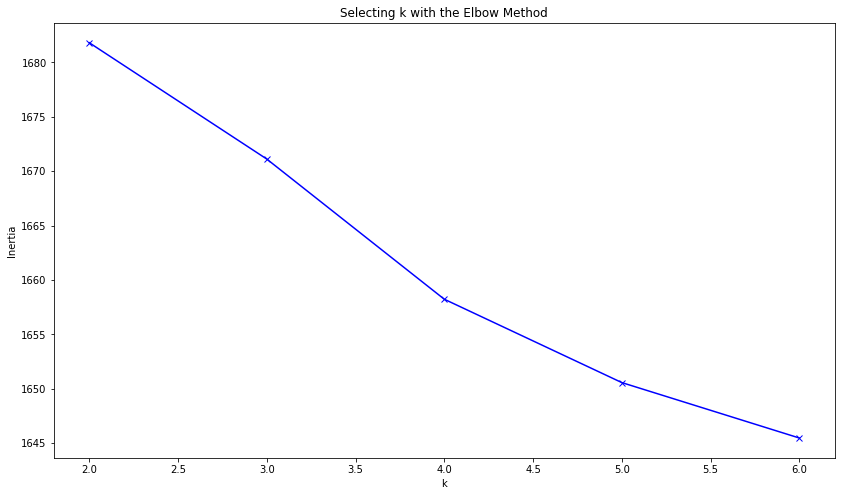

In [58]:
# plot elbow method chart
plt.figure(figsize=(14, 8))
plt.plot(K, ksu_inertia_scores, 'bx-') 
plt.xlabel('k') 
plt.ylabel('Inertia') 
plt.title('Selecting k with the Elbow Method') 

In [59]:
# display finding for k-value
print "Now that we know the right k-value to use, let's continue with our analysis on this score."

Now that we know the right k-value to use, let's continue with our analysis on this score.


In [60]:
#k is the number of clusters you're looking for ... this number is usually based on your domain knowledge
np.random.seed(1) # setting random seed to get the same results each time.

k = 3

tfidf_vectorizer = TfidfVectorizer(stop_words='english', decode_error='ignore')
X = tfidf_vectorizer.fit_transform(content1)
model = KMeans(n_clusters=k, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [61]:
# transform X to a matrix ... document term matrix
dtm = X.toarray()
dtm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
# transform data matrix to dataframe (Excel)
pd.DataFrame(dtm,columns=tfidf_vectorizer.get_feature_names())

000  00am  00pm   10  100   11  110   12   13   14 ...   year     years  \
0     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
2     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
3     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
4     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
5     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
6     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.099879   
7     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
8     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
9     0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
10    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
11    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
12    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
13    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
14    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.194887   
15    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
16    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
17    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
18    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
19    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
20    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
21    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
22    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
23    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
24    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
25    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
26    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
27    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
28    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
29    0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.244733   
...   ...   ...   ...  ...  ...  ...  ...  ...  ...  ... ...    ...       ...   
1710  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1711  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1712  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1713  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1714  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1715  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1716  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1717  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1718  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1719  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1720  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1721  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1722  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1723  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1724  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1725  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1726  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0  0.000000   
1727  0.0   0.0   0.0  0.0  0.0  0.0 

In [63]:
# labels_ : Labels of each point
cluster_name = model.labels_
print cluster_name

[2 0 2 ... 0 1 0]


In [64]:
# change documents to dataframe
df = pd.DataFrame(content1, columns = ['documents'])
df

documents
0     Kansas State was my first choice in schools to...
1     Amazing! I enjoyed every little thing about it...
2     Kansas State is such an amazing college. Every...
3     Kansas State University provides a very family...
4     I love how the campus really tries their best ...
5     i liked how my first visit there i already fel...
6     Kansas State is a great place to be if you are...
7     Upon entering the town of Manhattan, there is ...
8     The campus is lively and incredibly beautiful!...
9     Great place to meet friends, make awesome memo...
10    The last time I visited K-State the people tre...
11    It gives me a safe environment to learn. I hav...
12    Kansas state university is a great school with...
13    Kansas State University has so many options an...
14    K-State overall is a great school that offers ...
15    Very eye opening. Faculty always willing to he...
16    The community surrounding it is very welcoming...
17    I have loved my time here! It is a beautiful c...
18    Kansas State University is a very diverse univ...
19    I have had a mostly positive experience at Kan...
20    Kansas State University has so far been a very...
21    Kansas State University has a great, warm, fam...
22    Kansas State University is known for its famil...
23    I like the fact that even though it’s a big ca...
24    Kansas State University is like an Amazing Wel...
25    When I first stepped foot on this campus I imm...
26    Friendly environment, safe, good professors an...
27    I am located at Kansas State Polytechnic, whic...
28    Very Loving and caring schools that genuinely ...
29    I am an incoming freshman who has been visitin...
...                                                 ...
1710  The people at K-State are amazing. I absolutel...
1711  Just like at any other school, there are a lot...
1712  I love the nightlife around campus. Whenever I...
1713  I love all of my floor-mates and the food is g...
1714  Hey, If you're from Kansas, or going to a Kans...
1715         We don't really have public transportation
1716       All of our student life facilities are great
1717  All of our buildings have to have some limestone.
1718                    I like it but some people don't
1719                It is a pretty far walk to anywhere
1720                                                   
1721                                                   
1722                                                   
1723                                                   
1724                                                   
1725                                                   
1726                                                   
1727                                                   
1728                                                   
1729                                                   
1730                                                   
1731                                                   
1732  I love the nightlife around campus. Whenever I...
1733  I love all of my floor-mates and the food is g...
1734  Hey, If you're from Kansas, or going to a Kans...
1735         We don't really have public transportation
1736       All of our student life facilities are great
1737  All of our buildings have to have some limestone.
1738                    I like it but some people don't
1739                It is a pretty far walk to anywhere

[1740 rows x 1 columns]

In [65]:
# change cluster to dataframe
df1 = pd.DataFrame(model.labels_, columns = ['cluster'])
df1

cluster
0           2
1           0
2           2
3           2
4           1
5           2
6           2
7           0
8           2
9           2
10          2
11          0
12          2
13          2
14          2
15          2
16          1
17          2
18          2
19          2
20          2
21          2
22          2
23          1
24          2
25          2
26          0
27          0
28          0
29          0
...       ...
1710        2
1711        0
1712        0
1713        0
1714        2
1715        1
1716        2
1717        0
1718        1
1719        0
1720        0
1721        0
1722        0
1723        0
1724        0
1725        0
1726        0
1727        0
1728        0
1729        0
1730        0
1731        0
1732        0
1733        0
1734        2
1735        1
1736        2
1737        0
1738        1
1739        0

[1740 rows x 1 columns]

In [66]:
# join the two dataframe into one
df2 = df.join(df1)
df2

documents  cluster
0     Kansas State was my first choice in schools to...        2
1     Amazing! I enjoyed every little thing about it...        0
2     Kansas State is such an amazing college. Every...        2
3     Kansas State University provides a very family...        2
4     I love how the campus really tries their best ...        1
5     i liked how my first visit there i already fel...        2
6     Kansas State is a great place to be if you are...        2
7     Upon entering the town of Manhattan, there is ...        0
8     The campus is lively and incredibly beautiful!...        2
9     Great place to meet friends, make awesome memo...        2
10    The last time I visited K-State the people tre...        2
11    It gives me a safe environment to learn. I hav...        0
12    Kansas state university is a great school with...        2
13    Kansas State University has so many options an...        2
14    K-State overall is a great school that offers ...        2
15    Very eye opening. Faculty always willing to he...        2
16    The community surrounding it is very welcoming...        1
17    I have loved my time here! It is a beautiful c...        2
18    Kansas State University is a very diverse univ...        2
19    I have had a mostly positive experience at Kan...        2
20    Kansas State University has so far been a very...        2
21    Kansas State University has a great, warm, fam...        2
22    Kansas State University is known for its famil...        2
23    I like the fact that even though it’s a big ca...        1
24    Kansas State University is like an Amazing Wel...        2
25    When I first stepped foot on this campus I imm...        2
26    Friendly environment, safe, good professors an...        0
27    I am located at Kansas State Polytechnic, whic...        0
28    Very Loving and caring schools that genuinely ...        0
29    I am an incoming freshman who has been visitin...        0
...                                                 ...      ...
1710  The people at K-State are amazing. I absolutel...        2
1711  Just like at any other school, there are a lot...        0
1712  I love the nightlife around campus. Whenever I...        0
1713  I love all of my floor-mates and the food is g...        0
1714  Hey, If you're from Kansas, or going to a Kans...        2
1715         We don't really have public transportation        1
1716       All of our student life facilities are great        2
1717  All of our buildings have to have some limestone.        0
1718                    I like it but some people don't        1
1719                It is a pretty far walk to anywhere        0
1720                                                           0
1721                                                           0
1722                                                           0
1723                                                           0
1724                                                           0
1725                                                           0
1726                                                           0
1727                                                           0
1728                                                           0
1729                                                           0
1730                                                           0
1731                                                           0
1732  I love the nightlife around campus. Whenever I...        0
1733  I love all of my floor-mates and the food is g...        0
1734  Hey, If you're from Kansas, or going to a Kans...        2
1735         We don't really have public transportation        1
1736       All of our student life facilities are great        2
1737  All of our buildings have to have some limestone.        0
1738                    I like it but some people don't        1
1739                It is a pretty far walk to anywhere        0

[1740 rows x 2 

In [67]:
# this shows which words are significant for each cluster
model.cluster_centers_

array([[0.00108339, 0.00040335, 0.00040335, ..., 0.00039522, 0.00022689,
        0.00079307],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00047734, 0.        , 0.        , ..., 0.        , 0.00051419,
        0.        ]])

In [68]:
# T is transpose 
pd.DataFrame(model.cluster_centers_, columns=tfidf_vectorizer.get_feature_names()).T

0         1         2
000         0.001083  0.000000  0.000477
00am        0.000403  0.000000  0.000000
00pm        0.000403  0.000000  0.000000
10          0.002264  0.000000  0.000874
100         0.000167  0.001511  0.000000
11          0.000202  0.000000  0.000000
110         0.000189  0.000000  0.000000
12          0.000688  0.000000  0.000927
13          0.000215  0.000000  0.000478
14          0.000000  0.000000  0.000475
15          0.000656  0.000000  0.000000
150         0.000200  0.000000  0.000000
170         0.000175  0.000000  0.000000
18          0.000365  0.000000  0.000000
1st         0.000223  0.000000  0.000514
20          0.000798  0.002406  0.000461
200         0.000000  0.000000  0.000597
2013        0.000176  0.000000  0.000000
2015        0.000273  0.000000  0.000000
2016        0.000097  0.000000  0.000000
2017        0.000000  0.000000  0.001561
2025        0.000240  0.000000  0.000000
21          0.001104  0.000000  0.000000
23          0.000227  0.000000  0.000000
24          0.000285  0.000000  0.000868
25          0.000861  0.000000  0.000000
250         0.000538  0.000000  0.000000
2am         0.000271  0.000000  0.000000
2nd         0.000235  0.000000  0.000000
30          0.000975  0.000894  0.000398
...              ...       ...       ...
workout     0.000194  0.000000  0.000000
works       0.000911  0.000000  0.000000
world       0.001723  0.003737  0.002877
worn        0.000198  0.000000  0.000000
worried     0.000266  0.001983  0.000594
worrisome   0.000314  0.000000  0.000000
worry       0.000550  0.000000  0.000432
worshiped   0.000239  0.000000  0.000000
worst       0.001422  0.000000  0.000549
worth       0.001707  0.001210  0.003013
worthwhile  0.000515  0.001556  0.000000
wouldn      0.002959  0.000000  0.003937
writing     0.000873  0.000000  0.000000
written     0.000000  0.000000  0.000663
wrong       0.000994  0.001576  0.000000
xii         0.000187  0.000000  0.000000
yard        0.000140  0.000000  0.000000
yards       0.000227  0.000000  0.000000
yea         0.000000  0.000000  0.000762
yeah        0.000250  0.000000  0.000000
year        0.009339  0.007831  0.005378
years       0.003309  0.002930  0.003169
yes         0.000491  0.000000  0.002445
york        0.000487  0.000000  0.000000
young       0.000811  0.002223  0.000000
younger     0.000460  0.000000  0.000000
yucky       0.000423  0.000000  0.000000
zile        0.000395  0.000000  0.000000
zone        0.000227  0.000000  0.000514
zoo         0.000793  0.000000  0.000000

[3497 rows x 3 columns]

In [69]:
# determine popular word list from cluster
popularwordlist = pd.DataFrame(model.cluster_centers_, columns=tfidf_vectorizer.get_feature_names()).T
popularwordlist.sort_values([0, 1], ascending=[1,0])
# sort data by column 0 in the ascending order

0         1         2
associate    0.000000  0.006516  0.001449
maybe        0.000000  0.005408  0.000531
hanging      0.000000  0.005361  0.001158
talks        0.000000  0.005066  0.000000
profesors    0.000000  0.004426  0.000000
seamlessly   0.000000  0.003918  0.000000
irrelevant   0.000000  0.003801  0.000000
boys         0.000000  0.003796  0.000000
matters      0.000000  0.003693  0.000000
silly        0.000000  0.003693  0.000000
lc           0.000000  0.003687  0.000000
survey       0.000000  0.003669  0.000000
harsh        0.000000  0.003456  0.000000
labeled      0.000000  0.003347  0.000000
surround     0.000000  0.003328  0.000000
parting      0.000000  0.003211  0.000000
indifferent  0.000000  0.003166  0.000000
vegan        0.000000  0.003130  0.000000
pledging     0.000000  0.003110  0.000000
saying       0.000000  0.003066  0.000439
reality      0.000000  0.003010  0.000000
minus        0.000000  0.002894  0.000000
assume       0.000000  0.002839  0.000000
cops         0.000000  0.002839  0.000000
enhances     0.000000  0.002813  0.000000
butt         0.000000  0.002794  0.000000
whatnot      0.000000  0.002794  0.000000
board        0.000000  0.002754  0.000000
fafsa        0.000000  0.002754  0.000000
evolves      0.000000  0.002688  0.000000
...               ...       ...       ...
living       0.009495  0.016737  0.001047
want         0.009611  0.007531  0.011371
different    0.009647  0.001374  0.009945
feel         0.009700  0.016162  0.033296
easy         0.009722  0.008856  0.011154
housing      0.009992  0.007513  0.003642
things       0.010234  0.015781  0.008335
helpful      0.010318  0.011086  0.011026
live         0.010491  0.021772  0.004458
places       0.010894  0.001952  0.000956
time         0.010905  0.012880  0.012333
classes      0.010925  0.010120  0.008656
lots         0.011158  0.000976  0.001283
best         0.011574  0.006836  0.015114
student      0.011634  0.005200  0.018126
options      0.011658  0.006469  0.004363
just         0.011772  0.015105  0.013208
safe         0.012075  0.002704  0.006478
professors   0.012082  0.017441  0.013977
dorms        0.012315  0.021458  0.002547
food         0.012419  0.004164  0.002310
like         0.012453  0.026167  0.037184
people       0.014279  0.037085  0.045395
pretty       0.014712  0.012581  0.007754
lot          0.015503  0.026336  0.012276
good         0.015812  0.033327  0.007271
school       0.016877  0.010860  0.055875
students     0.020565  0.017226  0.029409
great        0.026295  0.026288  0.048585
campus       0.043930  0.040532  0.034469

[3497 rows x 3 columns]

In [70]:
# printing top words
model.cluster_centers_

array([[0.00108339, 0.00040335, 0.00040335, ..., 0.00039522, 0.00022689,
        0.00079307],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00047734, 0.        , 0.        , ..., 0.        , 0.00051419,
        0.        ]])

In [71]:
# here descending order
model.cluster_centers_.argsort()[:, ::-1]

array([[ 473, 1360, 2998, ...,  411, 1946, 1641],
       [2490,  913,  473, ..., 2172, 2171,    0],
       [2946, 1849, 1696, ..., 2085, 2084, 1748]], dtype=int64)

In [72]:
#generate an csv file for this word list (or word frequency analysis) per cluster
#using this word frequency, you can find more information about the documents in each cluster.

wordlist_per_cluster = pd.DataFrame(model.cluster_centers_, columns=tfidf_vectorizer.get_feature_names()).T
wordlist_per_cluster.to_csv("data\wordlist_per_cluster.csv", encoding='utf8', header=False, index=False)

In [73]:
# get top five words for each cluster

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

for i in range(k):
    print "Cluster: ", i,
    for ind in order_centroids[i, :5]:
        print terms[ind],
    print    

Top terms per cluster:
Cluster:  0 campus great students school good
Cluster:  1 really don campus know people
Cluster:  2 state love kansas family greek


In [74]:
# further text processing and prep for dendrogram
tfidf_vectorizer = TfidfVectorizer(stop_words='english', decode_error='ignore')
X = tfidf_vectorizer.fit_transform(content1)
dtm = X.toarray()
ward_model = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(dtm)
ward_model.labels_

array([2, 0, 2, ..., 0, 0, 0], dtype=int64)

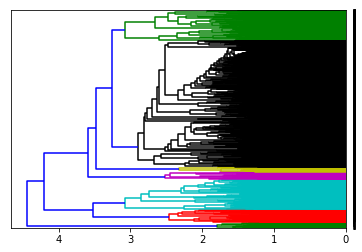

<Figure size 2304x1152 with 0 Axes>

In [75]:
# create "Dendrogram" plot of clusters
linkage_matrix = ward(dtm)
dendrogram(linkage_matrix, orientation="left", labels=ward_model.labels_)#content1)
plt.figure(figsize=(32,16))
plt.tight_layout()  # fixes margins

plt.savefig('data/ksu_ward_clusters.png', dpi=200) #save figure as ward_clusters

# 7. Final analysis & storytelling (technical and managerial implications and suggestions).

- Through all of this analysis, we found in KS the best college / dorm from the Niche website is KSU (ranked 200) and the worst college / dorm is KU (not ranked). 
- We analyzed the text of the reviews to see if their sentiment was positive, negative, or neutral. 
- Of the text in the reviews, we determined what words were used the most (word frequency and wordcloud).
- Clustering of the reviews was made to see where they all appeared.
- In the end, between KSU and KU, the former had more positive reviews, total reviews, and better statistics compared to the latter.
- The managerial implications are that KSU is doing a better job, both with more likeable residential areas on campus and as a college altogether. HDS knows it needs to keep a full compliment of facility and custodial staff for each of the residential areas to keep the residential students happy, safe, and feel like they are at home. 

# References:
https://www.analyticsvidhya.com/blog/2015/10/beginner-guide-web-scraping-beautiful-soup-python/

https://www.crummy.com/software/BeautifulSoup/bs4/doc/

http://www.gregreda.com/2013/03/03/web-scraping-101-with-python/

https://medium.freecodecamp.org/how-to-scrape-websites-with-python-and-beautifulsoup-5946935d93fe

http://selenium-python.readthedocs.io/locating-elements.html

## Other References:
- Dr. B. Chae, for providing additional material not covered in class (Selenium, K-Means Clustering Methods).